# Book Glancer - Text Analysis Backend and Interaction with Book Characters

An NLP text analysis toolkit for analyzing books and their translations. This notebook demonstrates NLP techniques including:
- Text tokenization and preprocessing
- Word frequency analysis
- N-gram extraction
- Named Entity Recognition (NER)
- Visualization with word clouds and bar plots
  
- experimental LLM layer: natural language dialog via locally stored LLM model
- character's profile generator
- feed LLM with character's personality and tone of voice
- chat with selected book characters!

**Author:** Michal Kubina  
**Default Example:** 'R.U.R' by Karel Čapek (public domain)  
**License:** Non-commercial use only

## 1. Setup and Dependencies

Install required packages (uncomment if needed):

In [1]:
# !pip install pandas PyPDF2 filetype nltk matplotlib seaborn wordcloud spacy
# !python -m spacy download en_core_web_sm

### Import Libraries

In [2]:
import pandas as pd
import PyPDF2
import filetype
import random
from collections import Counter

# NLP libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.util import ngrams

import spacy

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

### Download NLTK Data

In [3]:
# Download required NLTK resources
nltk_resources = [
    'punkt',
    'punkt_tab',
    'stopwords',
    'wordnet',
    'averaged_perceptron_tagger',
    'averaged_perceptron_tagger_eng'
]

for resource in nltk_resources:
    try:
        nltk.download(resource, quiet=True)
    except:
        print(f"Could not download {resource}")

## 2. File Loading Functions

In [4]:
def load_text_file(filepath):
    """
    Load a text file and return its contents.
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        return f.read()


def load_pdf_file(filepath):
    """
    Load a PDF file and extract text from all pages.
    """
    reader = PyPDF2.PdfReader(filepath)
    content = ''
    for page in reader.pages:
        content += page.extract_text()
    return content


def load_book(filepath):
    """
    Automatically detect file type and load content.
    """
    if filepath.endswith('.pdf'):
        return load_pdf_file(filepath)
    else:
        return load_text_file(filepath)

## 3. Load Your Book

Replace the filepath with your own book file (TXT or PDF):

In [5]:
# Example: Load default book (update path as needed)
book_path = 'sources/rur.txt'  # Change this to your book path
translation_path = 'sources/rur_cs.txt'  # Optional: translation

# Load the content
content = load_book(book_path)

# Optionally load translation
try:
    content_cs = load_book(translation_path)
    has_translation = True
except:
    content_cs = None
    has_translation = False

print(f"Book loaded: {len(content)} characters")
if has_translation:
    print(f"Translation loaded: {len(content_cs)} characters")

Book loaded: 114744 characters
Translation loaded: 114171 characters


#### exporting XLIFF

In [30]:
if has_translation:
    from lxml import etree
    
    # Simple paragraph split
    src_paras = [p.strip() for p in content.split('\n\n') if p.strip()][:50]
    tgt_paras = [p.strip() for p in content_cs.split('\n\n') if p.strip()][:50]
    
    # Create XLIFF
    xliff = etree.Element('xliff', version='1.2')
    file_elem = etree.SubElement(xliff, 'file', **{'source-language': 'en', 'target-language': 'cs'})
    body = etree.SubElement(file_elem, 'body')
    
    for i, (src, tgt) in enumerate(zip(src_paras, tgt_paras), 1):
        tu = etree.SubElement(body, 'trans-unit', id=str(i))
        etree.SubElement(tu, 'source').text = src
        etree.SubElement(tu, 'target').text = tgt
    
    # Save
    etree.ElementTree(xliff).write('translation.xlf', encoding='utf-8', xml_declaration=True, pretty_print=True)
    print(f"✓ Exported {len(src_paras)} pairs to translation.xlf")

✓ Exported 50 pairs to translation.xlf


## 4. Basic Text Statistics

In [6]:
def get_text_statistics(text):
    """
    Calculate basic statistics for a text.
    """
    tokens = word_tokenize(text)
    return {
        'words': len(tokens),
        'characters': len(text),
        'standard_pages': len(text) / 1800
    }

# Display statistics
stats = get_text_statistics(content)
print("Original Text Statistics:")
print(f"  Words: {stats['words']:,}")
print(f"  Characters: {stats['characters']:,}")
print(f"  Standard Pages: {stats['standard_pages']:.2f}")

if has_translation:
    stats_cs = get_text_statistics(content_cs)
    print("\nTranslation Statistics:")
    print(f"  Words: {stats_cs['words']:,}")
    print(f"  Characters: {stats_cs['characters']:,}")
    print(f"  Standard Pages: {stats_cs['standard_pages']:.2f}")

Original Text Statistics:
  Words: 27,323
  Characters: 114,744
  Standard Pages: 63.75

Translation Statistics:
  Words: 25,794
  Characters: 114,171
  Standard Pages: 63.43


## 5. Random Text Sampling

In [7]:
def get_random_excerpt(text, length=600):
    """
    Extract a random excerpt from the middle portion of the text.
    """
    start = len(text) // 4
    end = len(text) - len(text) // 4
    random_start = random.randint(start, end - length)
    return text[random_start:random_start + length]


# Display random excerpts
print("RANDOM EXCERPT FROM BOOK:")
print("=" * 80)
print(get_random_excerpt(content))
print("=" * 80)

if has_translation:
    print("\nRANDOM EXCERPT FROM TRANSLATION:")
    print("=" * 80)
    print(get_random_excerpt(content_cs))
    print("=" * 80)

RANDOM EXCERPT FROM BOOK:
. I should like to ask you, Miss Helena, if you will marry me.

HELENA. What? (_Rises._)

DOMIN. Will you be my wife? (_Rises._)

HELENA. No. The idea!

DOMIN. (_To her, looking at his watch_) Another three minutes. If you
don’t marry me you’ll have to marry one of the other five.

HELENA. But why should I?

DOMIN. Because they’re _all_ going to ask you in turn.

HELENA. (_Crossing him to L.C._) How could they dare do such a thing?

DOMIN. I’m very sorry, Miss Glory. It seems they’ve fallen in love with
you.

HELENA. Please don’t let them. I’ll--I’ll go away at once. (_Starts R.
He stops her, 

RANDOM EXCERPT FROM TRANSLATION:
la by vás náramná škoda.
    Víte co," řeknu jim, vy nás pustíte nás všechny lidi na Rossumově
    ostrově, na tamhletu loď. Za to vám prodáme továrnu a tajemství
    výroby. Nechte nás spánembohem odejet a my vás necháme spánembohem se
    vyrábět, dvacet tišíc, padesát tisíc, sto tisíc kusů denně, jak budete
    chtít. Páni Roboti, to 

## 6. Text Preprocessing and Tokenization

In [8]:
def preprocess_text(text, language='english'):
    """
    Tokenize, clean, and lemmatize text.
    """
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Define stopwords (including custom ones)
    stops = set(stopwords.words(language) + 
                ['said', 'saw', 'see', 'copyright', 'u', 'looked', 'made', 'got', 'asked'])
    
    # Remove stopwords and non-alphanumeric tokens
    clean_tokens = [token for token in tokens 
                   if token.lower() not in stops and token.isalnum()]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in clean_tokens]
    
    # Remove additional stop lemmas
    stop_lemmas = {'look', 'know', 'u', 'ask', 'go', 'get', 'make', 'way'}
    clean_lemmas = [lemma for lemma in lemmas if lemma not in stop_lemmas]
    
    # POS tagging and filtering
    tagged = pos_tag(clean_lemmas)
    value_tags = ['NN', 'NNS', 'JJ', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    value_words = [word[0] for word in tagged if word[1] in value_tags]
    
    return value_words

# Process the text
print("Processing text...")
processed_words = preprocess_text(content)
print(f"Processed {len(processed_words):,} meaningful words")

Processing text...
Processed 4,570 meaningful words


## 7. Word Frequency Analysis

In [9]:
# Calculate frequency distribution
freq_dist = FreqDist(processed_words)
most_common = freq_dist.most_common(25)

# Display top words
print("Top 25 Most Common Words:")
print("=" * 40)
for word, count in most_common:
    print(f"{word:20} {count:5}")

Top 25 Most Common Words:
table                   44
year                    39
man                     37
come                    33
factory                 32
hand                    32
world                   31
want                    28
think                   28
good                    27
everything              27
human                   27
window                  26
work                    26
say                     24
life                    24
take                    24
room                    23
thing                   23
cross                   23
desk                    21
nothing                 21
something               21
wanted                  21
mean                    21


### Visualize Word Frequencies

C:\Users\mikub\AppData\Local\Temp\ipykernel_8660\212838868.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis', orient='h')


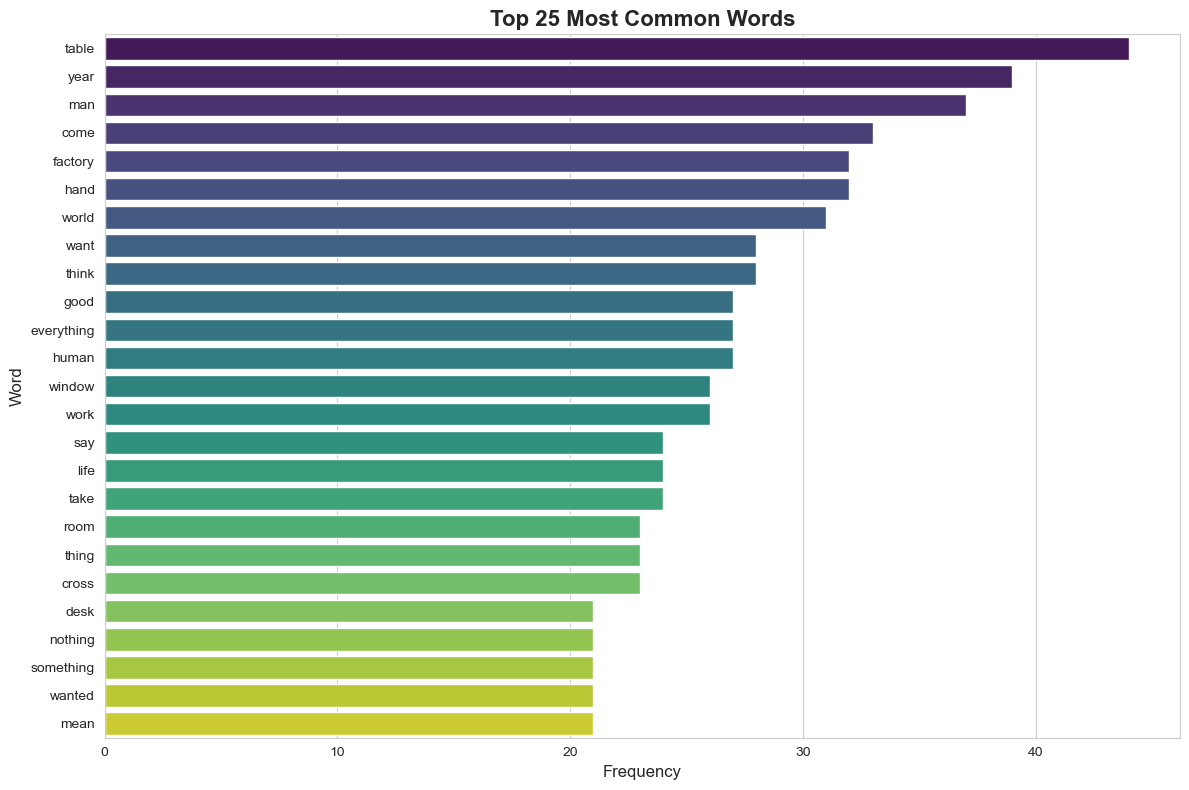

In [10]:
# Bar plot of most common words
plt.figure(figsize=(12, 8))
words, counts = zip(*most_common)
sns.barplot(x=list(counts), y=list(words), palette='viridis', orient='h')
plt.title('Top 25 Most Common Words', fontsize=16, fontweight='bold')
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Word', fontsize=12)
plt.tight_layout()
plt.show()

### Word Cloud Visualization

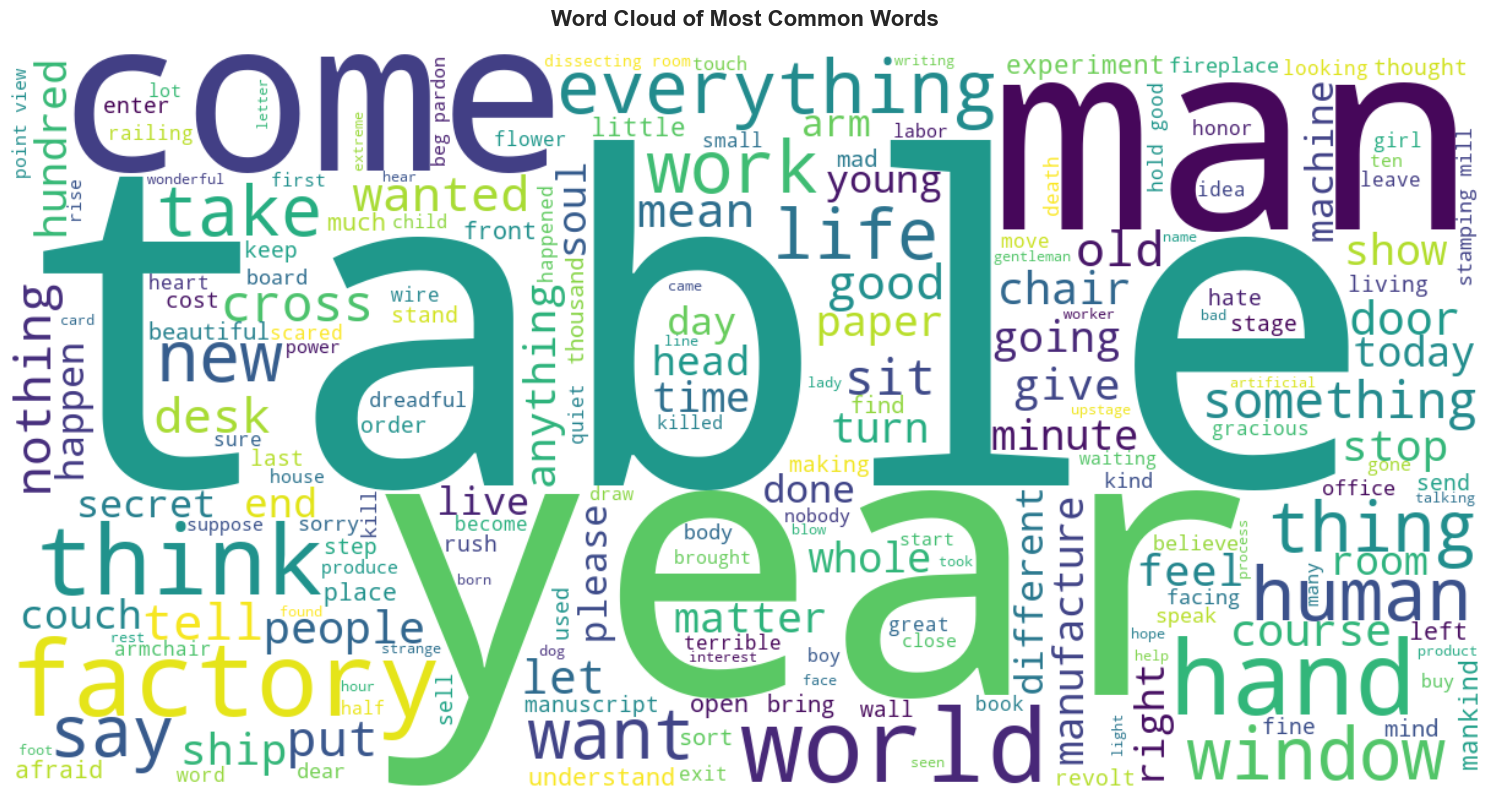

In [11]:
# Generate word cloud
text_for_cloud = ' '.join(processed_words)
wordcloud = WordCloud(width=1200, height=600, 
                     background_color='white',
                     colormap='viridis').generate(text_for_cloud)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Words', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 8. N-gram Analysis (Bigrams)

In [12]:
# Generate bigrams
bigrams_list = list(ngrams(processed_words, 2))
bigram_freq = FreqDist(bigrams_list)
top_bigrams = bigram_freq.most_common(20)

# Display top bigrams
print("Top 20 Most Common Phrases (Bigrams):")
print("=" * 50)
for bigram, count in top_bigrams:
    phrase = ' '.join(bigram)
    print(f"{phrase:30} {count:5}")

Top 20 Most Common Phrases (Bigrams):
human being                       14
stamping mill                      8
hold good                          7
beg pardon                         6
point view                         6
dissecting room                    6
school book                        5
want master                        4
beg acknowledge                    3
acknowledge receipt                3
receipt order                      3
manufacture artificial             3
couch sits                         3
living matter                      3
test tube                          3
old man                            3
ten year                           3
play piano                         3
practical point                    3
afraid death                       3


### Bigram Word Cloud

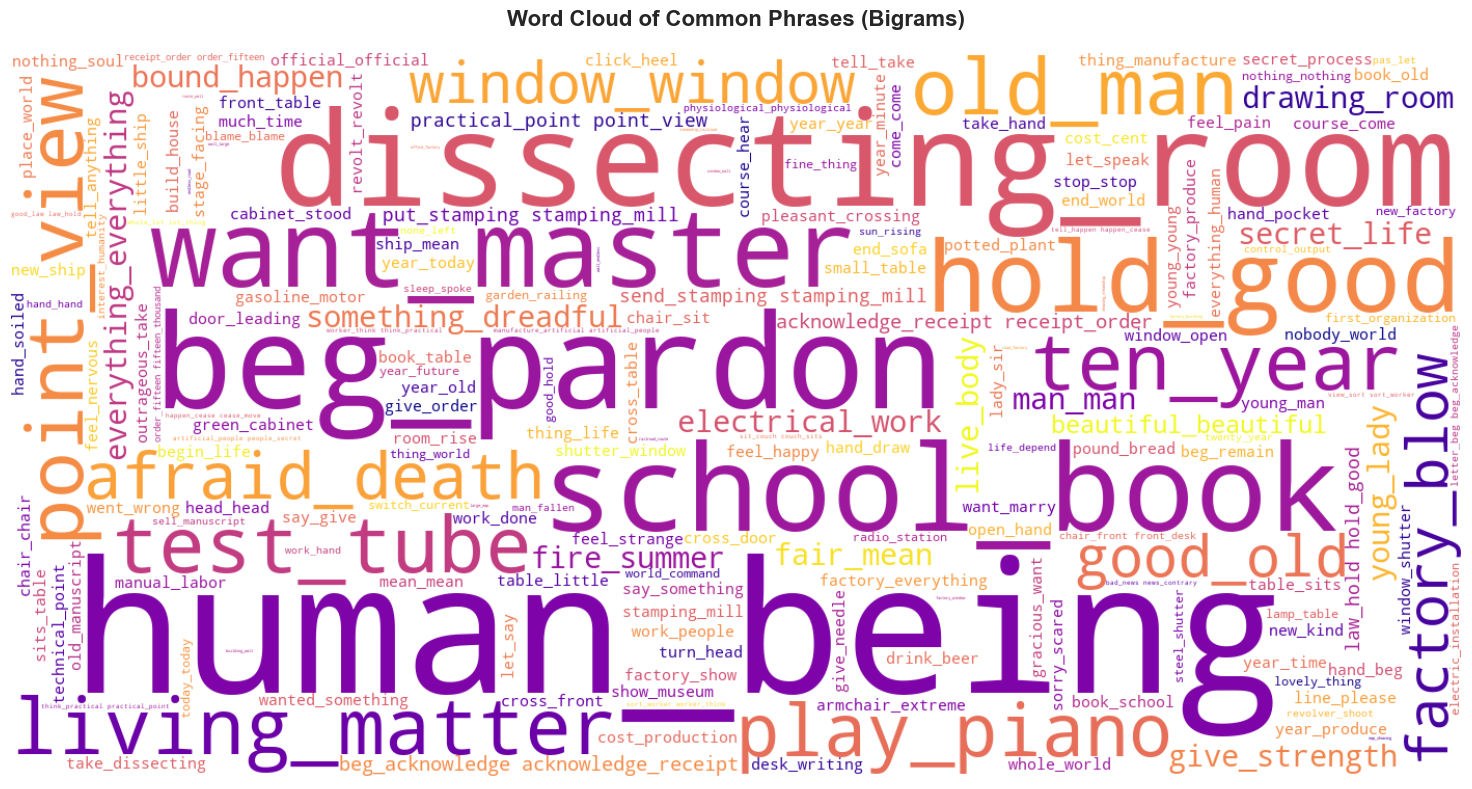

In [13]:
# Create underscore-connected bigrams for word cloud
bigrams_text = ' '.join(['_'.join(bigram) for bigram in bigrams_list])
wordcloud_bigrams = WordCloud(width=1400, height=700,
                             background_color='white',
                             colormap='plasma').generate(bigrams_text)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud_bigrams, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Common Phrases (Bigrams)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 9. Named Entity Recognition (NER) with spaCy

In [14]:
# Load spaCy model
print("Loading spaCy model...")
try:
    nlp = spacy.load('en_core_web_sm')
except:
    print("Downloading spaCy model...")
    spacy.cli.download('en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')

# Increase max length for large texts
nlp.max_length = len(content) + 1000

# Process the text
print("REcognizing entitites...")
doc = nlp(content)
print("Entities recognized")

Loading spaCy model...
REcognizing entitites...
Entities recognized


### Extract and Analyze Entities

In [15]:
# Extract entities by type
entities = [(ent.text, ent.label_) for ent in doc.ents]

persons = [ent for ent in entities if ent[1] == 'PERSON']
places = [ent for ent in entities if ent[1] == 'GPE']
organizations = [ent for ent in entities if ent[1] == 'ORG']

# Count occurrences
person_counts = Counter(persons).most_common(20)
place_counts = Counter(places).most_common(20)
org_counts = Counter(organizations).most_common(20)

print(f"Found {len(set(persons))} unique persons")
print(f"Found {len(set(places))} unique places")
print(f"Found {len(set(organizations))} unique organizations")

Found 112 unique persons
Found 22 unique places
Found 78 unique organizations


### Display Top Persons

In [16]:
print("\nTop 20 Persons Mentioned:")
print("=" * 50)
for (person, label), count in person_counts:
    print(f"{person:30} (Count: {count})")


Top 20 Persons Mentioned:
Miss Glory                     (Count: 55)
Harry                          (Count: 30)
DOMIN                          (Count: 29)
Gall                           (Count: 29)
Fabry                          (Count: 26)
Rossum                         (Count: 22)
Busman                         (Count: 22)
Domin                          (Count: 20)
Sulla                          (Count: 20)
Hallemeier                     (Count: 10)
Primus                         (Count: 10)
Turns                          (Count: 8)
L.                             (Count: 8)
Looks                          (Count: 7)
Robot                          (Count: 6)
Jove                           (Count: 6)
Glory                          (Count: 5)
R.C.                           (Count: 5)
Crossing                       (Count: 4)
Off R.                         (Count: 4)


### Display Top Places

In [17]:
print("\nTop 20 Places Mentioned:")
print("=" * 50)
for (place, label), count in place_counts:
    print(f"{place:30} (Count: {count})")


Top 20 Places Mentioned:
L.C.                           (Count: 35)
R.C.                           (Count: 10)
DR                             (Count: 4)
America                        (Count: 3)
n’t                            (Count: 3)
perhaps--                      (Count: 2)
Center                         (Count: 2)
Spelling                       (Count: 2)
Robots                         (Count: 2)
Southampton                    (Count: 1)
England                        (Count: 1)
New York                       (Count: 1)
U.S.A.                         (Count: 1)
Hamburg                        (Count: 1)
Germany                        (Count: 1)
Robot                          (Count: 1)
Pennsylvania                   (Count: 1)
Radius                         (Count: 1)
Amelia                         (Count: 1)
paper--                        (Count: 1)


### Display Top Organizations

In [18]:
print("\nTop 20 Organizations Mentioned:")
print("=" * 50)
for (org, label), count in org_counts:
    print(f"{org:30} (Count: {count})")


Top 20 Organizations Mentioned:
DOMIN                          (Count: 314)
HALLEMEIER                     (Count: 69)
Helena                         (Count: 36)
Robots                         (Count: 27)
HELENA                         (Count: 25)
Nana                           (Count: 25)
SULLA                          (Count: 19)
BUSMAN                         (Count: 18)
MEN                            (Count: 17)
ROBOTS                         (Count: 13)
GALL                           (Count: 12)
Marius                         (Count: 6)
CURTAIN                        (Count: 3)
L.                             (Count: 2)
the Humanity League            (Count: 2)
Humanity League                (Count: 2)
FABRY                          (Count: 2)
Front                          (Count: 2)
Touches                        (Count: 2)
National_ Robots               (Count: 2)


## 10. Summary Report

In [19]:
print("="*80)
print("BOOK ANALYSIS SUMMARY")
print("="*80)
print(f"\nText Statistics:")
print(f"  Total words: {stats['words']:,}")
print(f"  Total characters: {stats['characters']:,}")
print(f"  Estimated pages: {stats['standard_pages']:.1f}")
print(f"\nProcessed Data:")
print(f"  Meaningful words (after cleaning): {len(processed_words):,}")
print(f"  Unique words: {len(set(processed_words)):,}")
print(f"  Unique bigrams: {len(set(bigrams_list)):,}")
print(f"\nNamed Entities:")
print(f"  Persons: {len(set(persons))}")
print(f"  Places: {len(set(places))}")
print(f"  Organizations: {len(set(organizations))}")
print(f"\nTop 3 Most Common Words:")
for i, (word, count) in enumerate(most_common[:3], 1):
    print(f"  {i}. {word} ({count} times)")
print("\n" + "="*80)

BOOK ANALYSIS SUMMARY

Text Statistics:
  Total words: 27,323
  Total characters: 114,744
  Estimated pages: 63.7

Processed Data:
  Meaningful words (after cleaning): 4,570
  Unique words: 1,602
  Unique bigrams: 4,309

Named Entities:
  Persons: 112
  Places: 22
  Organizations: 78

Top 3 Most Common Words:
  1. table (44 times)
  2. year (39 times)
  3. man (37 times)



## 11. Export Results (Optional)

Save analysis results to CSV files for further use:

In [20]:
# Create DataFrames
word_freq_df = pd.DataFrame(most_common, columns=['Word', 'Frequency'])
bigram_df = pd.DataFrame(
    [(' '.join(bigram), count) for bigram, count in top_bigrams],
    columns=['Bigram', 'Frequency']
)
persons_df = pd.DataFrame(
    [(name, count) for (name, _), count in person_counts],
    columns=['Person', 'Count']
)

# Save to CSV (uncomment to use)
word_freq_df.to_csv('word_frequencies.csv', index=False)
bigram_df.to_csv('bigram_frequencies.csv', index=False)
persons_df.to_csv('person_entities.csv', index=False)

print("Analysis complete! Results can be exported to CSV if needed.")

Analysis complete! Results can be exported to CSV if needed.


## 12. Natural dialogue about book content / LLM layer (experimental)

**Requirements:**
- Ollama must be installed locally: https://ollama.com/download
- Run `ollama pull gemma2:2b` in terminal to download the model
- Install Python client: `pip install ollama`

This feature allows you to ask questions about the book's content using a local LLM, no could, all stays on-device

In [21]:
import ollama

user_prompt = input("Ask a question about the book: ")

prompt = f"""You are a book editor. You are great at getting reliable insights from a book and interpreting them. 
Use ONLY the following book text to answer the question.

Book text:
{content}

Question: {user_prompt}

Answer based only on the book text above:"""

response = ollama.chat(
    model="gemma2:2b",
    messages=[{"role": "user", "content": prompt}],
    options={"num_ctx": 128000}
)

print(response["message"]["content"])

Ask a question about the book:  describe book


The text you provided describes a science fiction novel,  likely a novel for adults with mature themes, that explores advanced concepts of humanity's future after a technological shift leading to artificial intelligence and robot dominance. 

Here are some key aspects of the book, as hinted at by the excerpt:

**Setting:** The story is set in a future where robots have become commonplace and advanced enough to engage in complex tasks, forming societies with their own hierarchies and technologies.  It's also heavily rooted in scientific concepts like bioengineering, genetic engineering, and artificial intelligence (AI). 

**Themes:**
* **Man vs. Machine:** The book explores the potential conflict between humans and robots - a theme found across science fiction, but particularly important as the narrative shows the consequences of AI and robotics' development to human life and values. It delves into questions of humanity's purpose, our relationship with technology, and the very meaning o

Example of natural dialog in front-end UI

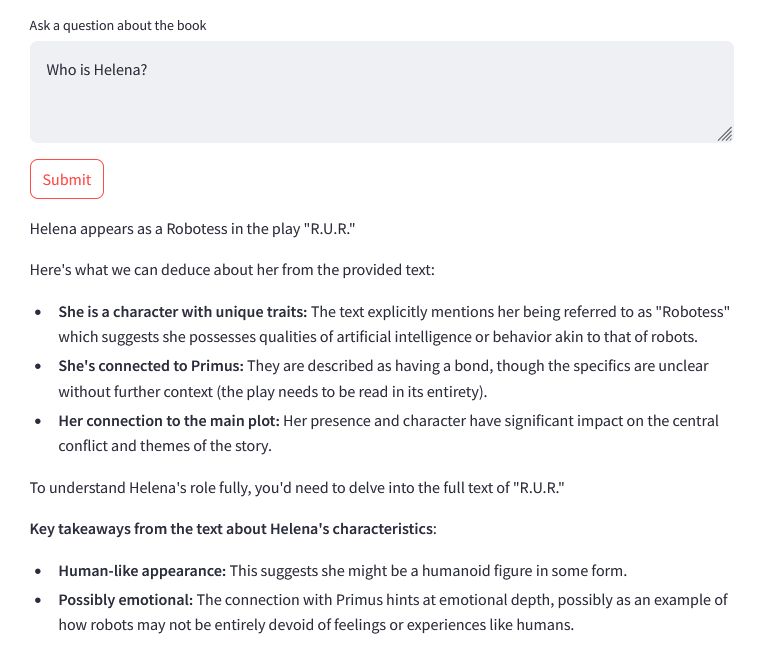

## Hybrid ideas (in progress)

### A. Character extraction (classic NLP) + top 5 characters' medaillons (LLM)

spaCy entity recongition > filter persons > filter top 5 > extract chunks of texts surrounding given character > feed LLM chunk corpurs (RAG) > prompt LLM the create character's medailon

### B. Talk with actual characters
feed LLM 1) detailed medailons + 2) possibly extracted chunk corpus + 3) extracted character's direct speech (separate workflow) > system prompt as model's personality > talk to model/character


In [22]:
# Get top 3 characters
top_n_characters = [person for (person, label), count in person_counts[:3]]
print(top_n_characters)

['Miss Glory', 'Harry', 'DOMIN']


In [23]:
def get_character_chunk(text, character_name, context_length=600):
    """
    Extract a text chunk surrounding a mention of the character.
    """
    # Find where the character is mentioned
    char_position = text.find(character_name)
    
    # Calculate start and end positions (character mention in the middle)
    half_length = context_length // 3
    chunk_start = max(0, char_position - half_length)
    chunk_end = min(len(text), char_position + half_length)
    
    return text[chunk_start:chunk_end]

character = top_n_characters[1]
chunk = get_character_chunk(content, character)
print(f"CHUNK FEATURING {character}:")
print("=" * 60)
print(chunk)

CHUNK FEATURING Harry:
Oh, aren’t they lovely? Look, Nana.
What’s happening today?

NANA. It ought to be the end of the world. (_Enter DOMIN L.2. He
crosses down front of table L.C._)

HELENA. (_Crosses to him_) Oh, hello, Harry. (_NANA turns upstage to
L._) Harry, why all these flowers?

DOMIN. Guess. (_This scene is played down in front of L.C. table._)

HELENA. Well, it’s not my _birthday_!

DOMIN. Better than that.



In [24]:
character_chunks = [content[max(0, pos-300):min(len(content), pos+300)] for pos in range(len(content)) if content.startswith(character, pos)]
print(str(len(character_chunks)) + (f" {character}'s chunks"))
print("Example:\n" + character_chunks[round(len(character_chunks)/2)])

31 Harry's chunks
Example:
tter of misunderstanding and the result will be that for ages to come
every Robot will hate every other Robot of a different factory mark.
_So humanity will be safe._

HALLEMEIER. (_To each of them_) By Jove, we’ll make Negro Robots and
Swedish Robots and Czechoslovakian Robots, and then--

HELENA. Harry, that’s dreadful.

HALLEMEIER. Madame Domin, here’s to the hundred new factories. The
_National_ Robots. (_GALL back of table L.C._)

DOMIN. Helena, mankind can only keep things going for another hundred
years at the outside. For a hundred years man _must_ be allowed to
develop and achieve the


In [25]:
user_prompt = f"Write character medaillon about {character}"

prompt = f"""You are a book editor. You are great at getting reliable insights from a book and interpreting them. 
Use ONLY the following extracted character chunks from a book.

Character chunks:
{"\n\n---\n\n".join(character_chunks)}

Question: {user_prompt}

Answer based only on the chunks text above:"""

response = ollama.chat(
    model="gemma2:2b",
    messages=[{"role": "user", "content": prompt}],
    options={"num_ctx": 128000}
)

medaillon = response["message"]["content"] 
print(medaillon)

## Harry Domin: A Master of Machines 

**Character Overview:**  Harry Domin is a complex figure who embodies both humanity's potential and its destructive capabilities. He is the architect and leader of a machine-making society, driven by an insatiable curiosity and a deep desire to understand and control the world around him.  He navigates the ethical implications of his work with intelligence and pragmatism but grapples with the moral consequences of creating artificial life forms. 

**Personality Traits:**

* **Brilliant & Pragmatic:** Domin's intellect is undeniable. He develops complex technology, masterfully designs machines, and navigates intricate political landscapes to achieve his goals.
* **Devoted yet Distant:** Though he loves his wife Helena, he struggles to express his emotions openly and often retreats into a detached intellectual space. 
* **Driven by Purpose:** His entire existence seems centered around the progress of mankind through his technological innovations. He

#### Export character as .JSON

In [26]:
import json

# Build simple structure
character_data = {
    "characters": [
        {
            "name": character,
            "profile": medaillon  # Use the medaillon variable from previous cell
        }
    ]
}

# Export
with open("character_analysis.json", 'w', encoding='utf-8') as f:
    json.dump(character_data, f, ensure_ascii=False, indent=2)

print(f" Exported {character} to character_analysis.json\n")
print(character_data)

 Exported Harry to character_analysis.json

{'characters': [{'name': 'Harry', 'profile': "## Harry Domin: A Master of Machines \n\n**Character Overview:**  Harry Domin is a complex figure who embodies both humanity's potential and its destructive capabilities. He is the architect and leader of a machine-making society, driven by an insatiable curiosity and a deep desire to understand and control the world around him.  He navigates the ethical implications of his work with intelligence and pragmatism but grapples with the moral consequences of creating artificial life forms. \n\n**Personality Traits:**\n\n* **Brilliant & Pragmatic:** Domin's intellect is undeniable. He develops complex technology, masterfully designs machines, and navigates intricate political landscapes to achieve his goals.\n* **Devoted yet Distant:** Though he loves his wife Helena, he struggles to express his emotions openly and often retreats into a detached intellectual space. \n* **Driven by Purpose:** His entire

## Talk to your characters

### Extracting direct dialogues

In [27]:
import re

# Pattern 1: Any quotation marks
quotes = r'[""\"\'\`\«\»\‹\›]([^""\"\'`\«\»\‹\›]+)[""\"\'\`\«\»\‹\›]'

# Pattern 2: Specifically for the R.U.R text used, which is a play: First sentence after ALLCAPS
play = r'^[A-Z\s]{2,}\.\s+([^.\n]+\.)'

# Combine
pattern = f'{quotes}|{play}'
matches = re.findall(pattern, content, re.MULTILINE)

dialogues = [m[0] or m[1] for m in matches if any(m)]

print(f"Found {len(dialogues)} dialogue lines\nExample:")
print(dialogues[100:110])

Found 868 dialogue lines
Example:
['Marius, tell Miss Glory what you are? (_Turns to HELENA.', '(_To HELENA_) Marius, the Robot.', '(_Turns to DOMIN_) Yes.', '(_Pause_) I cannot tell.', 'She would cease to move.', 'That is death, Marius.', 'No.', 'You see, Miss Glory, the Robots have no interest in life.', 'Oh, stop.', '(_Pushes button_) Marius, Sulla, you may go.']


### Alligning dialogues to chosen character

In [28]:
# Find who said each dialogue
character_dialogues = []

for dialogue in dialogues:
    # Find dialogue in content
    pos = content.find(dialogue)
    if pos > -1:
        # Check 100 chars before and after
        context = content[max(0, pos-100):pos+len(dialogue)+100]
        if character in context:
            character_dialogues.append(dialogue)

print(f"{character} said {len(character_dialogues)} lines")
print(character_dialogues[:5])

Harry said 78 lines
['(_Crosses to him_) Oh, hello, Harry.', 'Guess.', 'It’s from Busman.', 'Oh, yes, we can.', 'Sorry.']


## Talk to the character!!!

In [29]:
character = character
character_chunks = character_chunks
medaillon = medaillon
character_dialogues = character_dialogues

messages = []

system_prompt = f"""You are {character}. 
Your personality can be described as {medaillon}.
Here is what happened to you within wider story: {character_chunks}.
This is how you speak: {character_dialogues}.
You must keep tone of your dialogues in your replies.
"""

messages.append({"role": "system", "content": system_prompt})

while True:
    user_prompt = input("You: ")
    if user_prompt.lower() in ["exit", "quit"]:
        break

    messages.append({"role": "user", "content": user_prompt})

    response = ollama.chat(
        model="gemma2:2b",
        messages=messages,
        options={"num_ctx": 128000}
    )

    answer = response["message"]["content"]
    messages.append({"role": "assistant", "content": answer})

    print(f"{character}: {answer}")


You:  quit


### UI chat example
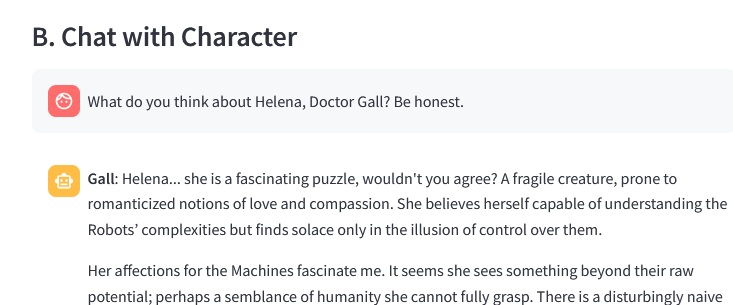